In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import time

from helper import readFile
from helper import oneHotEncoder
from helper import showConfusionMarix
from helper import getBatches
from NeuralNetwork import NeuralNetwork

%matplotlib inline

In [2]:
# read the data
trainFeature, trainLabel = readFile('./data/train/lab/hw2train_labels.txt', './data/')
devFeature, devLabel = readFile('./data/dev/lab/hw2dev_labels.txt', './data/')
evalFeature, evalLabel = readFile('./data/eval/lab/hw2eval_labels.txt', './data/')

# One-Hot-Encode for labels
trainLabel = oneHotEncoder(trainLabel, 9)
devLabel = oneHotEncoder(devLabel, 9)
evalLabel = oneHotEncoder(evalLabel, 9)

## TensorFlow

In [3]:
#########################################################
# Part 2: TensorFlow Analysis
print('*' * 60)
print('Part 2: TensorFlow Analysis\n')

# Help function for TensorFlow part
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def conv2d_valid(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='VALID')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], 
                          strides=[1, 2, 2, 1], padding='SAME')

************************************************************
Part 2: TensorFlow Analysis



## Original TDNN model

****************************************
Original TDNN model
****************************************
Step 1000, train, dev, eval accuracy 	0.41502, 0.41176, 0.37514,
Step 2000, train, dev, eval accuracy 	0.41265, 0.40082, 0.38944,
Step 3000, train, dev, eval accuracy 	0.42688, 0.40629, 0.36634,
Step 4000, train, dev, eval accuracy 	0.43024, 0.39398, 0.38174,
Step 5000, train, dev, eval accuracy 	0.51285, 0.47059, 0.44994,
Step 6000, train, dev, eval accuracy 	0.52194, 0.47332, 0.44994,
Step 7000, train, dev, eval accuracy 	0.52233, 0.4788, 0.44004,
Step 8000, train, dev, eval accuracy 	0.52312, 0.45828, 0.44114,
Step 9000, train, dev, eval accuracy 	0.51462, 0.48016, 0.44554,
Step 10000, train, dev, eval accuracy 	0.52727, 0.45964, 0.44004,
Training is done, total time	 2399.024 s

Best Model reached at iteration	 4511
Best Model Training Accuracy	 0.514032
Best Model Evaluation Accuracy	 0.455446


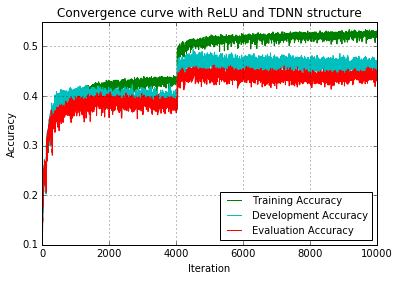

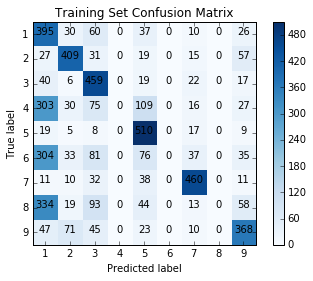

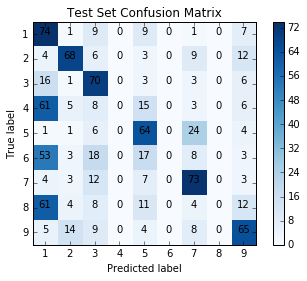

In [4]:
print('*' * 40)
print('Original TDNN model')
print('*' * 40)

# Hyper-parameters
batchSize = 50         # batch size
subIterate = 5         # select the first n batches from shuffled data
maxIterate = 10000      # maximum iteration
showFreq = 1000         # frequency to control the logging information
learningRate = 0.01    # learning rate

# define list to save the training and test accuracy
trainAcc = []
devAcc = []
evalAcc = []
trainPredict = []
evalPredict = []

# begin the session
sess = tf.InteractiveSession()
t0 = time.time()

# Create the model
x = tf.placeholder(tf.float32, shape=[None, 1120])
y_ = tf.placeholder(tf.float32, shape=[None, 9])

# reshape the input image
x_image = tf.reshape(x, [-1, 70, 16, 1])

# first convolutional layer
W_conv1 = weight_variable([3, 16, 1, 8])
b_conv1 = bias_variable([8])
# first processing
h_conv1 = tf.nn.relu(conv2d_valid(x_image, W_conv1) + b_conv1)
h_conv1 = tf.reshape(h_conv1, [-1, 68, 8, 1])

# second convolution layer
W_conv2 = weight_variable([5, 8, 1, 9])
b_conv2 = bias_variable([9])
# second processing
h_conv2 = tf.nn.relu(conv2d_valid(h_conv1, W_conv2) + b_conv2)

# readout layer
h_conv2 = tf.reshape(h_conv2, [-1, 64, 9])
h_mean = tf.reduce_mean(h_conv2, reduction_indices=1)
y_conv = tf.nn.softmax(h_mean)

# define cross entropy
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_conv), reduction_indices=[1]))
# train and test the model
train_step = tf.train.AdamOptimizer(learningRate).minimize(cross_entropy)
# predict the label
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
prediction = tf.argmax(y_conv, 1)

# start training
sess.run(tf.initialize_all_variables())

for i in range(1, maxIterate + 1):
    # shuffle and get batches
    X, y = shuffle(trainFeature, trainLabel)
    batchesX, batchesY = getBatches(X, y, batchSize)
    
    # training process
    j = 1
    for batchFeature, batchLabel in zip(batchesX, batchesY):
        if j == subIterate:
            break
        train_step.run(feed_dict={x: batchFeature, y_: batchLabel})
        j += 1
    
    # evaluate current model
    train_accuracy = accuracy.eval(feed_dict={x:trainFeature, y_: trainLabel})
    dev_accuracy = accuracy.eval(feed_dict={x:devFeature, y_: devLabel})
    eval_accuracy = accuracy.eval(feed_dict={x:evalFeature, y_: evalLabel})
    
    train_label = prediction.eval(feed_dict={x: trainFeature})
    eval_label = prediction.eval(feed_dict={x: evalFeature})
    
    trainAcc.append(train_accuracy)
    devAcc.append(dev_accuracy)
    evalAcc.append(eval_accuracy)
    trainPredict.append(train_label)
    evalPredict.append(eval_label)
        
    # keep recording the current process
    if i % showFreq == 0:
        print("Step %d, train, dev, eval accuracy \t%g, %g, %g,"%(i, np.round(train_accuracy, 5), 
                                                                  np.round(dev_accuracy, 5), 
                                                                  np.round(eval_accuracy, 5)))

t = time.time() - t0
print('Training is done, total time\t', np.round(t, 4), 's\n')
sess.close()

# output the result
index = np.argmax(devAcc)
trainAccBest = trainAcc[index]
evalAccBest = evalAcc[index]
print('Best Model reached at iteration\t', index + 1)
print('Best Model Training Accuracy\t', trainAccBest)
print('Best Model Evaluation Accuracy\t', evalAccBest)

# plot the training accuracy
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(trainAcc, 'g', label='Training Accuracy')
ax.plot(devAcc, 'c', label='Development Accuracy')
ax.plot(evalAcc, 'r', label='Evaluation Accuracy')
ax.set_title('Convergence curve with ReLU and TDNN structure')
ax.set_xlabel('Iteration')
ax.set_ylabel('Accuracy')
ax.legend(loc=4, fontsize=10)
ax.grid('on')
plt.show()

# plot the training and test confusion matrix
trainMatrix = np.dot(trainLabel.T, oneHotEncoder(np.array([trainPredict[index]]).T, 9))
testMatrix = np.dot(evalLabel.T, oneHotEncoder(np.array([evalPredict[index]]).T, 9))

fig1 = showConfusionMarix(trainMatrix, title='Training Set Confusion Matrix', 
                          label=[str(i) for i in range(1, 10)])
fig1.savefig('./result/originalTDNNtrain.pdf')

fig2 = showConfusionMarix(testMatrix, title='Test Set Confusion Matrix', 
                          label=[str(i) for i in range(1, 10)])
fig2.savefig('./result/originalTDNNtest.pdf')

## Required TDNN modified model

****************************************
Modified TDNN model
****************************************
Step 200, train, dev, eval accuracy 	0.58123, 0.49658, 0.47525,
Step 400, train, dev, eval accuracy 	0.65474, 0.52257, 0.50495,
Step 600, train, dev, eval accuracy 	0.69209, 0.52804, 0.49835,
Step 800, train, dev, eval accuracy 	0.7415, 0.52394, 0.48075,
Step 1000, train, dev, eval accuracy 	0.76265, 0.52668, 0.49175,
Training is done, total time	 236.9228 s

Best Model reached at iteration	 569
Best Model Training Accuracy	 0.703953
Best Model Evaluation Accuracy	 0.514852


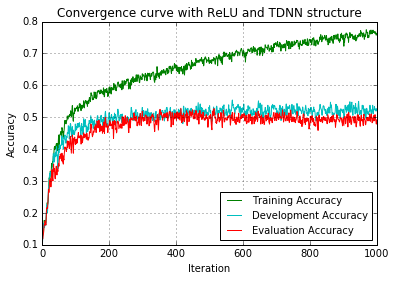

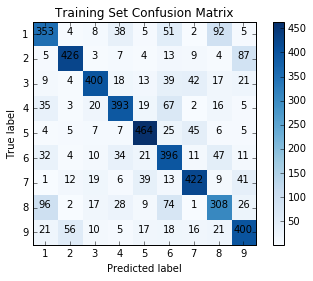

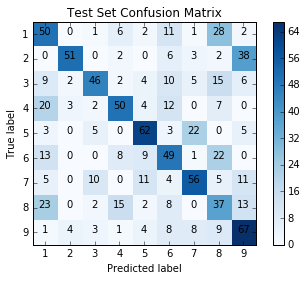

In [5]:
print('*' * 40)
print('Modified TDNN model')
print('*' * 40)

# Hyper-parameters
batchSize = 50          # batch size
subIterate = 5          # select the first n batches from shuffled data
maxIterate = 1000       # maximum iteration
showFreq = 200          # frequency to control the logging information
learningRate = 0.002    # learning rate

# define list to save the training and test accuracy
trainAcc = []
devAcc = []
evalAcc = []
trainPredict = []
evalPredict = []

# begin the session
sess = tf.InteractiveSession()
t0 = time.time()

# Create the model
x = tf.placeholder(tf.float32, shape=[None, 1120])
y_ = tf.placeholder(tf.float32, shape=[None, 9])

# reshape the input image
x_image = tf.reshape(x, [-1, 70, 16, 1])

# first convolutional layer
W_conv1 = weight_variable([3, 16, 1, 8])
b_conv1 = bias_variable([8])
# first processing
h_conv1 = tf.nn.relu(conv2d_valid(x_image, W_conv1) + b_conv1)
h_conv1 = tf.reshape(h_conv1, [-1, 68, 8, 1])

# second convolution layer
W_conv2 = weight_variable([5, 8, 1, 9])
b_conv2 = bias_variable([9])
# second processing
h_conv2 = tf.nn.relu(conv2d_valid(h_conv1, W_conv2) + b_conv2)

# Densely Connected Layer
W_fc = weight_variable([64 * 9, 9])
b_fc = bias_variable([9])

# readout layer
h_fc = tf.reshape(h_conv2, [-1, 64 * 9])
y_conv=tf.nn.softmax(tf.matmul(h_fc, W_fc) + b_fc)

# define cross entropy
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_conv), reduction_indices=[1]))
# train and test the model
train_step = tf.train.AdamOptimizer(learningRate).minimize(cross_entropy)
# predict the label
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
prediction = tf.argmax(y_conv, 1)

# start training
sess.run(tf.initialize_all_variables())

for i in range(1, maxIterate + 1):
    # shuffle and get batches
    X, y = shuffle(trainFeature, trainLabel)
    batchesX, batchesY = getBatches(X, y, batchSize)
    
    # training process
    j = 1
    for batchFeature, batchLabel in zip(batchesX, batchesY):
        if j == subIterate:
            break
        train_step.run(feed_dict={x: batchFeature, y_: batchLabel})
        j += 1
    
    # evaluate current model
    train_accuracy = accuracy.eval(feed_dict={x:trainFeature, y_: trainLabel})
    dev_accuracy = accuracy.eval(feed_dict={x:devFeature, y_: devLabel})
    eval_accuracy = accuracy.eval(feed_dict={x:evalFeature, y_: evalLabel})
    
    train_label = prediction.eval(feed_dict={x: trainFeature})
    eval_label = prediction.eval(feed_dict={x: evalFeature})
    
    trainAcc.append(train_accuracy)
    devAcc.append(dev_accuracy)
    evalAcc.append(eval_accuracy)
    trainPredict.append(train_label)
    evalPredict.append(eval_label)
        
    # keep recording the current process
    if i % showFreq == 0:
        print("Step %d, train, dev, eval accuracy \t%g, %g, %g,"%(i, np.round(train_accuracy, 5), 
                                                                  np.round(dev_accuracy, 5), 
                                                                  np.round(eval_accuracy, 5)))

t = time.time() - t0
print('Training is done, total time\t', np.round(t, 4), 's\n')
sess.close()

# output the result
index = np.argmax(devAcc)
trainAccBest = trainAcc[index]
evalAccBest = evalAcc[index]
print('Best Model reached at iteration\t', index + 1)
print('Best Model Training Accuracy\t', trainAccBest)
print('Best Model Evaluation Accuracy\t', evalAccBest)

# plot the training accuracy
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(trainAcc, 'g', label='Training Accuracy')
ax.plot(devAcc, 'c', label='Development Accuracy')
ax.plot(evalAcc, 'r', label='Evaluation Accuracy')
ax.set_title('Convergence curve with ReLU and TDNN structure')
ax.set_xlabel('Iteration')
ax.set_ylabel('Accuracy')
ax.legend(loc=4, fontsize=10)
ax.grid('on')
plt.show()

# plot the training and test confusion matrix
trainMatrix = np.dot(trainLabel.T, oneHotEncoder(np.array([trainPredict[index]]).T, 9))
testMatrix = np.dot(evalLabel.T, oneHotEncoder(np.array([evalPredict[index]]).T, 9))

fig1 = showConfusionMarix(trainMatrix, title='Training Set Confusion Matrix', 
                          label=[str(i) for i in range(1, 10)])
fig1.savefig('./result/requiredTDNNtrain.pdf')

fig2 = showConfusionMarix(testMatrix, title='Test Set Confusion Matrix', 
                          label=[str(i) for i in range(1, 10)])
fig2.savefig('./result/requiredTDNNtest.pdf')

## Flexible TDNN model

****************************************
Modified TDNN model
****************************************
Step 200, train, dev, eval accuracy 	0.50435, 0.42681, 0.41254,
Step 400, train, dev, eval accuracy 	0.51957, 0.43639, 0.44444,
Step 600, train, dev, eval accuracy 	0.56423, 0.47332, 0.45875,
Step 800, train, dev, eval accuracy 	0.56759, 0.47743, 0.45325,
Step 1000, train, dev, eval accuracy 	0.59368, 0.49111, 0.47525,
Training is done, total time	 220.5032 s

Best Model reached at iteration	 811
Best Model Training Accuracy	 0.585375
Best Model Evaluation Accuracy	 0.479648


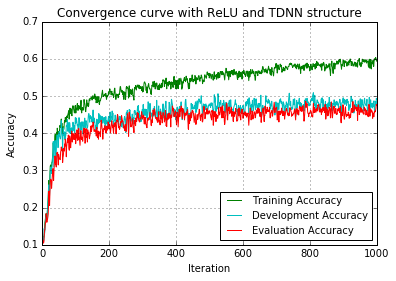

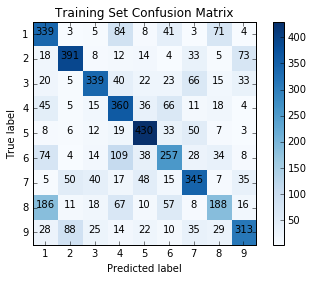

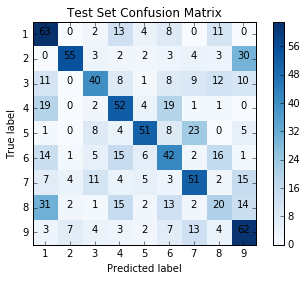

In [6]:
print('*' * 40)
print('Modified TDNN model')
print('*' * 40)

# define models
J1 = 16
N1 = 2
J2 = 8
N2 = 4
J3 = 3
N3 = 1

# Hyper-parameters
batchSize = 50          # batch size
subIterate = 5          # select the first n batches from shuffled data
maxIterate = 1000       # maximum iteration
showFreq = 200          # frequency to control the logging information
learningRate = 0.002    # learning rate

# define list to save the training and test accuracy
trainAcc = []
devAcc = []
evalAcc = []
trainPredict = []
evalPredict = []

# begin the session
sess = tf.InteractiveSession()
t0 = time.time()

# Create the model
x = tf.placeholder(tf.float32, shape=[None, 1120])
y_ = tf.placeholder(tf.float32, shape=[None, 9])

# reshape the input image
x_image = tf.reshape(x, [-1, 70, 16, 1])

# first convolutional layer
W_conv1 = weight_variable([N1 + 1, J1, 1, J2])
b_conv1 = bias_variable([J2])
# first processing
h_conv1 = tf.nn.relu(conv2d_valid(x_image, W_conv1) + b_conv1)
h_conv1 = tf.reshape(h_conv1, [-1, 70 - N1, J2, 1])

# second convolution layer
W_conv2 = weight_variable([N2 + 1, J2, 1, J3])
b_conv2 = bias_variable([J3])
# second processing
h_conv2 = tf.nn.relu(conv2d_valid(h_conv1, W_conv2) + b_conv2)

# Densely Connected Layer
W_fc = weight_variable([(70 - N1 - N2) * J3, 9])
b_fc = bias_variable([9])

# readout layer
h_fc = tf.reshape(h_conv2, [-1, (70 - N1 - N2) * J3])
y_conv=tf.nn.softmax(tf.matmul(h_fc, W_fc) + b_fc)

# define cross entropy
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_conv), reduction_indices=[1]))
# train and test the model
train_step = tf.train.AdamOptimizer(learningRate).minimize(cross_entropy)
# predict the label
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
prediction = tf.argmax(y_conv, 1)

# start training
sess.run(tf.initialize_all_variables())

for i in range(1, maxIterate + 1):
    # shuffle and get batches
    X, y = shuffle(trainFeature, trainLabel)
    batchesX, batchesY = getBatches(X, y, batchSize)
    
    # training process
    j = 1
    for batchFeature, batchLabel in zip(batchesX, batchesY):
        if j == subIterate:
            break
        train_step.run(feed_dict={x: batchFeature, y_: batchLabel})
        j += 1
    
    # evaluate current model
    train_accuracy = accuracy.eval(feed_dict={x:trainFeature, y_: trainLabel})
    dev_accuracy = accuracy.eval(feed_dict={x:devFeature, y_: devLabel})
    eval_accuracy = accuracy.eval(feed_dict={x:evalFeature, y_: evalLabel})
    
    train_label = prediction.eval(feed_dict={x: trainFeature})
    eval_label = prediction.eval(feed_dict={x: evalFeature})
    
    trainAcc.append(train_accuracy)
    devAcc.append(dev_accuracy)
    evalAcc.append(eval_accuracy)
    trainPredict.append(train_label)
    evalPredict.append(eval_label)
        
    # keep recording the current process
    if i % showFreq == 0:
        print("Step %d, train, dev, eval accuracy \t%g, %g, %g,"%(i, np.round(train_accuracy, 5), 
                                                                  np.round(dev_accuracy, 5), 
                                                                  np.round(eval_accuracy, 5)))

t = time.time() - t0
print('Training is done, total time\t', np.round(t, 4), 's\n')
sess.close()

# output the result
index = np.argmax(devAcc)
trainAccBest = trainAcc[index]
evalAccBest = evalAcc[index]
print('Best Model reached at iteration\t', index + 1)
print('Best Model Training Accuracy\t', trainAccBest)
print('Best Model Evaluation Accuracy\t', evalAccBest)

# plot the training accuracy
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(trainAcc, 'g', label='Training Accuracy')
ax.plot(devAcc, 'c', label='Development Accuracy')
ax.plot(evalAcc, 'r', label='Evaluation Accuracy')
ax.set_title('Convergence curve with ReLU and TDNN structure')
ax.set_xlabel('Iteration')
ax.set_ylabel('Accuracy')
ax.legend(loc=4, fontsize=10)
ax.grid('on')
plt.show()

# plot the training and test confusion matrix
trainMatrix = np.dot(trainLabel.T, oneHotEncoder(np.array([trainPredict[index]]).T, 9))
testMatrix = np.dot(evalLabel.T, oneHotEncoder(np.array([evalPredict[index]]).T, 9))

fig1 = showConfusionMarix(trainMatrix, title='Training Set Confusion Matrix', 
                          label=[str(i) for i in range(1, 10)])
fig1.savefig('./result/bestTDNNtrain.pdf')

fig2 = showConfusionMarix(testMatrix, title='Test Set Confusion Matrix', 
                          label=[str(i) for i in range(1, 10)])
fig2.savefig('./result/bestTDNNtest.pdf')